In [4]:
import random
import gym
import numpy as np
from IPython.display import clear_output
from time import sleep
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alpha = 0.001
gamma = 0.99

class VNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fcV1 = torch.nn.Linear(4, 256)
        self.fcV2 = torch.nn.Linear(256, 256)
        self.fcV3 = torch.nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.fcV1(x)
        x = torch.nn.functional.relu(x)
        x = self.fcV2(x)
        x = torch.nn.functional.relu(x)
        x = self.fcV3(x)
        return x
    
class PolicyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fcA1 = torch.nn.Linear(4, 256)
        self.fcA2 = torch.nn.Linear(256, 256)
        self.fcA3 = torch.nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.fcA1(x)
        x = torch.nn.functional.relu(x)
        x = self.fcA2(x)
        x = torch.nn.functional.relu(x)
        x = self.fcA3(x)  
        x = torch.nn.functional.softmax(x, dim=-1)
        return x
    
    
# network and optimizer
pi = PolicyNetwork().to(device)
pi_optimizer = torch.optim.Adam(pi.parameters(), lr=alpha)

V = VNetwork().to(device)
V_optimizer = torch.optim.Adam(V.parameters(), lr=alpha)    
    



def gen_episode():
    states = []
    actions = []
    rewards = []
    state = env.reset() 
    done = False
    score = 0
    while not done:
        probs = pi(torch.FloatTensor(state).to(device))
        action = torch.multinomial(probs, 1).item()
        next_state, reward, done, info = env.step(action)  # take a random action
        if done:
            reward = -10
            env.close()
        score = score + reward
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)    
        state = next_state
    return states, actions, rewards, score

def G(t):
    G = 0
    for tau in range(t, len(rewards)):
        G = G + gamma**(tau - t) * rewards[tau]
    return G
        
env = gym.make('CartPole-v1')

scores = [];
episode = 0
MAX_EPISODES = 200
while episode < MAX_EPISODES:  # episode loop
    states, actions, rewards, score = gen_episode()
    scores.append(score)
    loss1 = 0
    loss2 = 0
    for t in range(0, len(rewards)-1):
        s = states[t]
        a = actions[t]
        r = rewards[t]
        s=torch.FloatTensor(s).to(device)
        a=torch.tensor(a, dtype=torch.int8).to(device)
        r=torch.FloatTensor([r]).to(device)


        if t < (len(rewards)-2):
            next_s = states[t+1]
            next_s=torch.FloatTensor(next_s).to(device)
            with torch.no_grad():
                 A = r + gamma* V(next_s)-V(s)
            loss1 = loss1 - A * (gamma**t)* pi(s)[a].log()            
            
        else:
            with torch.no_grad():
                A = r-V(s)            
            loss1 = loss1 - A * (gamma**t)* pi(s)[a].log()
   
        loss2 = loss2 + (G(t) - V(s))**2
       
    loss1 = loss1/len(rewards)
    loss2 = loss2/len(rewards)
    
    pi_optimizer.zero_grad()
    loss1.backward()
    pi_optimizer.step()
    
    V_optimizer.zero_grad()
    loss2.backward()
    for k in range(1,3):
        V_optimizer.step()  

    
    
    
    
    print('episode: {}, reward: {:.1f}'.format(episode, score))
    episode = episode + 1
    



episode: 0, reward: 25.0
episode: 1, reward: 15.0
episode: 2, reward: 20.0
episode: 3, reward: -1.0
episode: 4, reward: 2.0
episode: 5, reward: 2.0
episode: 6, reward: -1.0
episode: 7, reward: -3.0
episode: 8, reward: 3.0
episode: 9, reward: -1.0
episode: 10, reward: 2.0
episode: 11, reward: 1.0
episode: 12, reward: -1.0
episode: 13, reward: 4.0
episode: 14, reward: 3.0
episode: 15, reward: -1.0
episode: 16, reward: 5.0
episode: 17, reward: 0.0
episode: 18, reward: -2.0
episode: 19, reward: 1.0
episode: 20, reward: -3.0
episode: 21, reward: 16.0
episode: 22, reward: 48.0
episode: 23, reward: 1.0
episode: 24, reward: 9.0
episode: 25, reward: 2.0
episode: 26, reward: 0.0
episode: 27, reward: 2.0
episode: 28, reward: 2.0
episode: 29, reward: 16.0
episode: 30, reward: -1.0
episode: 31, reward: 3.0
episode: 32, reward: 22.0
episode: 33, reward: 2.0
episode: 34, reward: 6.0
episode: 35, reward: 18.0
episode: 36, reward: 11.0
episode: 37, reward: 5.0
episode: 38, reward: 3.0
episode: 39, rewa

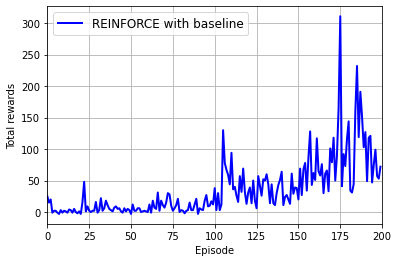

In [5]:


plt.plot(range(len(scores)), np.array(scores), 'b', linewidth = 2, label = 'REINFORCE with baseline')
plt.legend(prop={'size':12})
plt.xlabel('Episode')
plt.ylabel('Total rewards')
plt.xlim(0, MAX_EPISODES)
plt.grid(True)


In [7]:
# TEST   
episode = 0
state = env.reset()    
while episode < 5:  # episode loop
    env.render()
    probs = pi(torch.FloatTensor(state).to(device))     
    action = torch.multinomial(probs, 1).item()
    next_state, reward, done, info = env.step(action)  # take a random action
    state = next_state
    sleep(0.01)
    if done:
        reward = -10
        env.close()
    score = score + reward
    if done:
        episode = episode + 1
        print('Episode: {} Score: {}'.format(episode, score))
        state = env.reset()
env.close()    

Episode: 1 Score: 919.0
Episode: 2 Score: 1335.0
Episode: 3 Score: 1757.0
Episode: 4 Score: 2183.0
Episode: 5 Score: 2616.0
